In [153]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (10, 10
                                 ) 
plt.rcParams['axes.grid']=False
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

In [253]:
TEXT = ''
for i in range(1,17):
    f = open(str(i)+".txt", "r")
    TEXT = TEXT+ f.read() + ' '
    f.close()

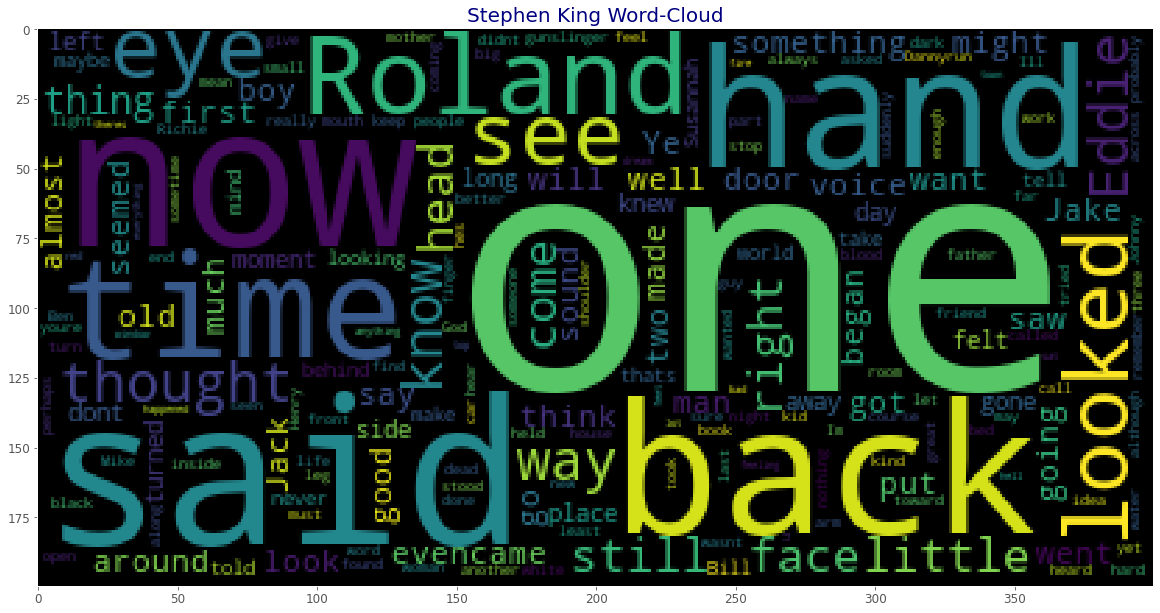

In [255]:
import wordcloud
wordcloud_text = wordcloud.WordCloud().generate(TEXT)
plt.rcParams['figure.figsize']=(20,20)
#plt.subplot(1,2,1)
plt.title('Stephen King Word-Cloud',color='navy',fontsize=20)
plt.imshow(wordcloud_text)

In [171]:
text = TEXT

In [223]:
text = TEXT[0:50000]

In [224]:
# The unique characters in the file
vocab = sorted(set(text))
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)


# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
# Batch size
BATCH_SIZE = 10

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [225]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(10, 100, 52) # (batch_size, sequence_length, vocab_size)


In [226]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
model.compile(optimizer='adam', loss=loss)
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
49/49 [==============================] - 81s 2s/step - loss: 3.7369
Epoch 2/30
49/49 [==============================] - 80s 2s/step - loss: 2.4315
Epoch 3/30
49/49 [==============================] - 78s 2s/step - loss: 2.2376
Epoch 4/30
49/49 [==============================] - 77s 2s/step - loss: 2.1463
Epoch 5/30
49/49 [==============================] - 80s 2s/step - loss: 2.0454
Epoch 6/30
49/49 [==============================] - 79s 2s/step - loss: 1.9754
Epoch 7/30
49/49 [==============================] - 77s 2s/step - loss: 1.8634
Epoch 8/30
49/49 [==============================] - 78s 2s/step - loss: 1.7804
Epoch 9/30
49/49 [==============================] - 79s 2s/step - loss: 1.6741
Epoch 10/30
49/49 [==============================] - 78s 2s/step - loss: 1.5814
Epoch 11/30
49/49 [==============================] - 78s 2s/step - loss: 1.4783
Epoch 12/30
49/49 [==============================] - 78s 2s/step - loss: 1.3618
Epoch 13/30
49/49 [==============================

In [227]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [235]:
def generate_text(model, start_string,t):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 100

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = t

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [241]:
print(generate_text(model, start_string=u"After the ",t=0.1))


After the sun was warm on our faces we were both wearing sweaters You know how confused dreams are  logic like


In [252]:
print(generate_text(model, start_string=u"So I decided ",t=0.1))


So I decided the ordinary was going on I think this was because in my heart I believed that such conditions only 


In [239]:
print(generate_text(model, start_string=u"I ",t=0.7))


I fell in love To the sound of breaking glass edged it like jagged lace The two ved her be a fluke I r


In [245]:
print(generate_text(model, start_string=u"We",t=0.9))


We Put the bost line I as we made love I realized a wonderful thing or two that she had meant it when 


In [240]:
print(generate_text(model, start_string=u"They",t=0.3))


They were bet me bect in the schoolyard by girls who have noticed his fly is unzipped It was comical but


In [256]:
print(generate_text(model, start_string=u"T",t=0.3))


The RedShirt Man Ironically one of the books the champagneHe slipped the chain over the bed with her 
